<a href="https://colab.research.google.com/github/adheeb4/7PAM2002_0509_2023_Final_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [1]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=f721a7c818f6984d55d8630cab36a567517e341392972a3d36cbfcd2e48c472a
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Data/'

fundamentals_df = pd.read_csv(file_path + 'fundamentals.csv')
prices_df = pd.read_csv(file_path + 'prices.csv')
prices_split_adjusted_df = pd.read_csv(file_path + 'prices-split-adjusted.csv')
securities_df = pd.read_csv(file_path + 'securities.csv')


prices_df['date'] = pd.to_datetime(prices_df['date'], format='mixed')

# Format the 'date' column to 'YYYY-MM-DD'
prices_df['date'] = prices_df['date'].dt.strftime('%Y-%m-%d')



print("Fundamentals Data")
print(fundamentals_df.head())

print("\nPrices Data")
print(prices_df.head())

print("\nPrices Split Adjusted Data")
print(prices_split_adjusted_df.head())

print("\nSecurities Data")
print(securities_df.head())

Fundamentals Data
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2    

In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth, filename='DataFrame'):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[float, int])
    df = df.dropna(axis='columns')  # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with more than 1 unique value

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
def plotScatterMatrix(df, plotSize, textSize, maxColumns=10):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[np.number])

    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique value

    if df.shape[1] < 2:
        print(f'No scatter matrix plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    # Limit the number of columns
    if df.shape[1] > maxColumns:
        print(f'Too many columns to display ({df.shape[1]}), displaying the first {maxColumns} columns.')
        df = df.iloc[:, :maxColumns]

    columnNames = list(df)
    df = df[columnNames].dropna()

    # Create scatter matrix
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')

    # Add title
    corr = df.corr().values
    for i, j in zip(*np.triu_indices_from(corr, 1)):
        ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)

    plt.suptitle('Scatter Matrix')
    plt.show()

Too many columns to display (71), displaying the first 10 columns.


<ipython-input-7-d8ec7bf7104e>:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)


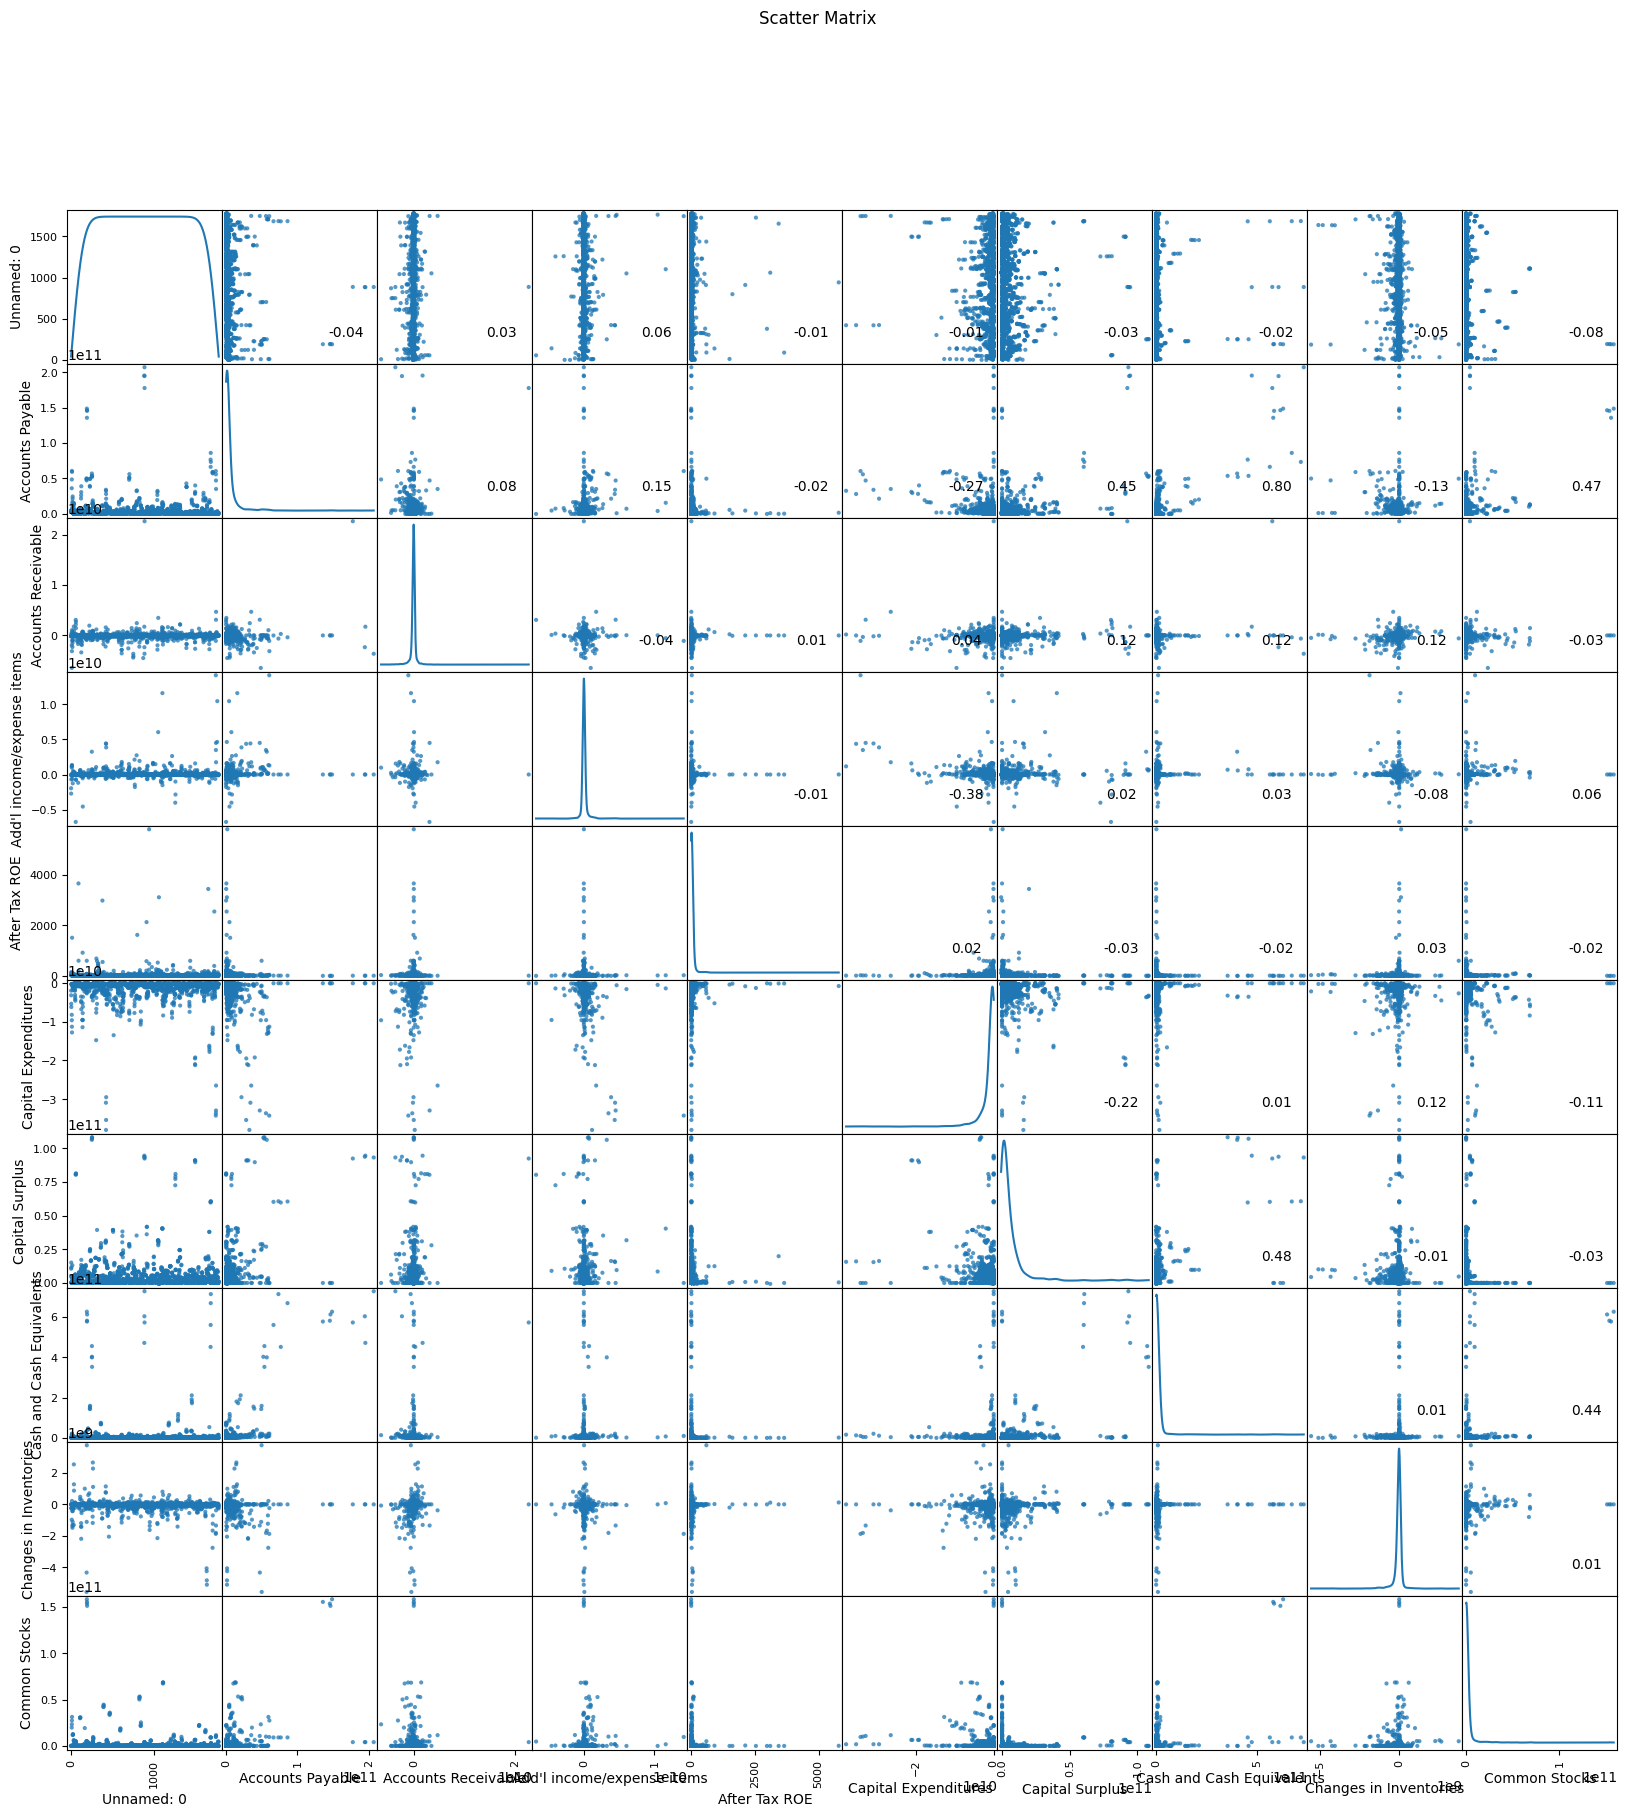

In [ ]:
plotScatterMatrix(fundamentals_df, 20, 10)

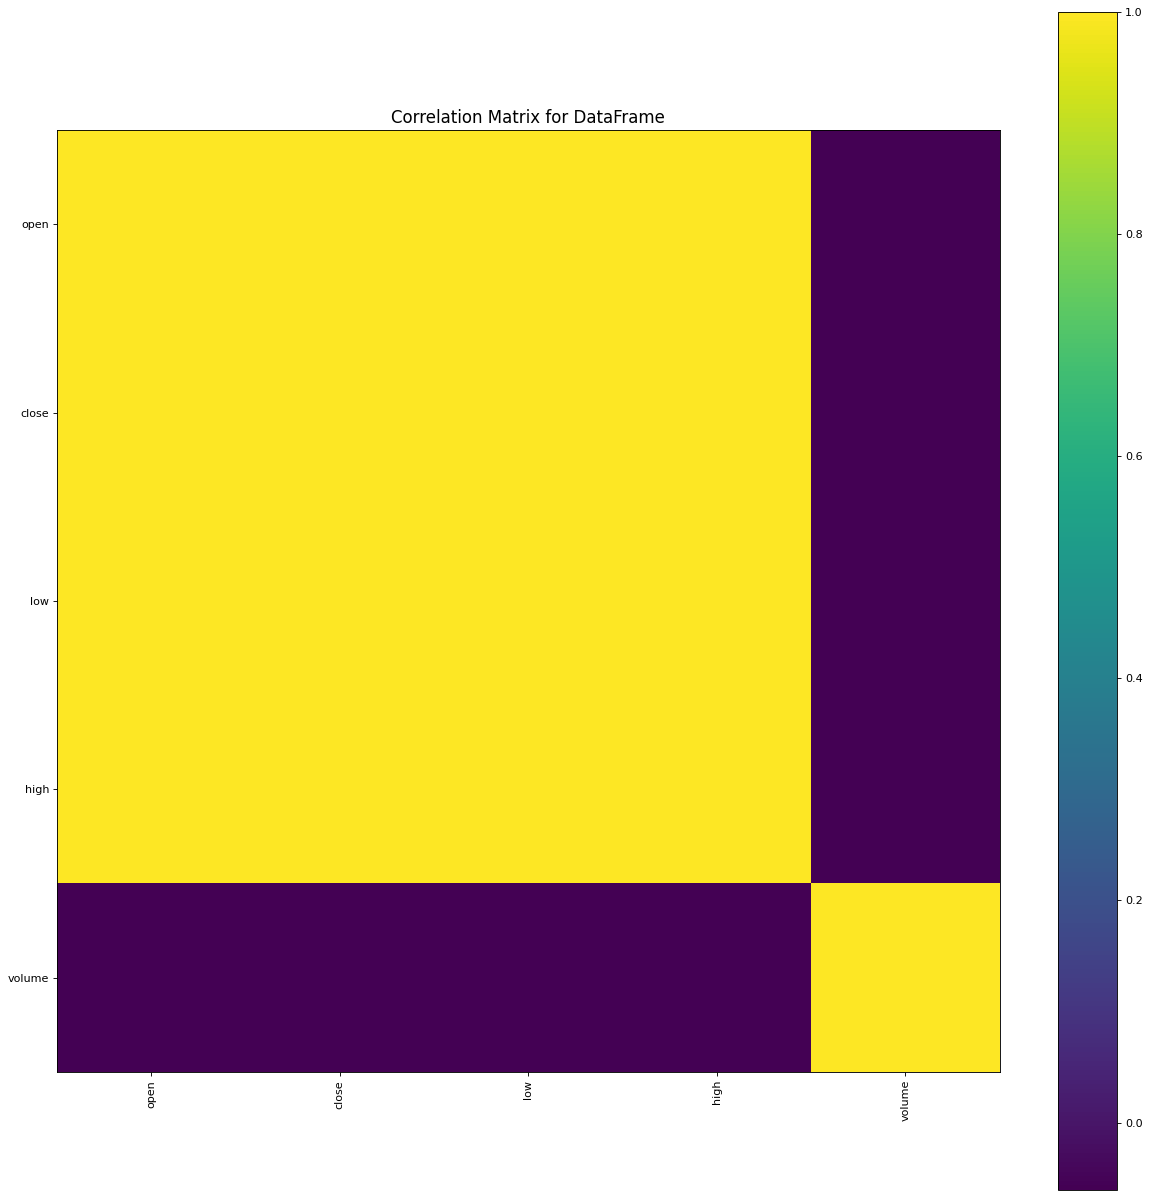

In [ ]:
plotCorrelationMatrix(prices_df, 19)

<ipython-input-7-d8ec7bf7104e>:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)


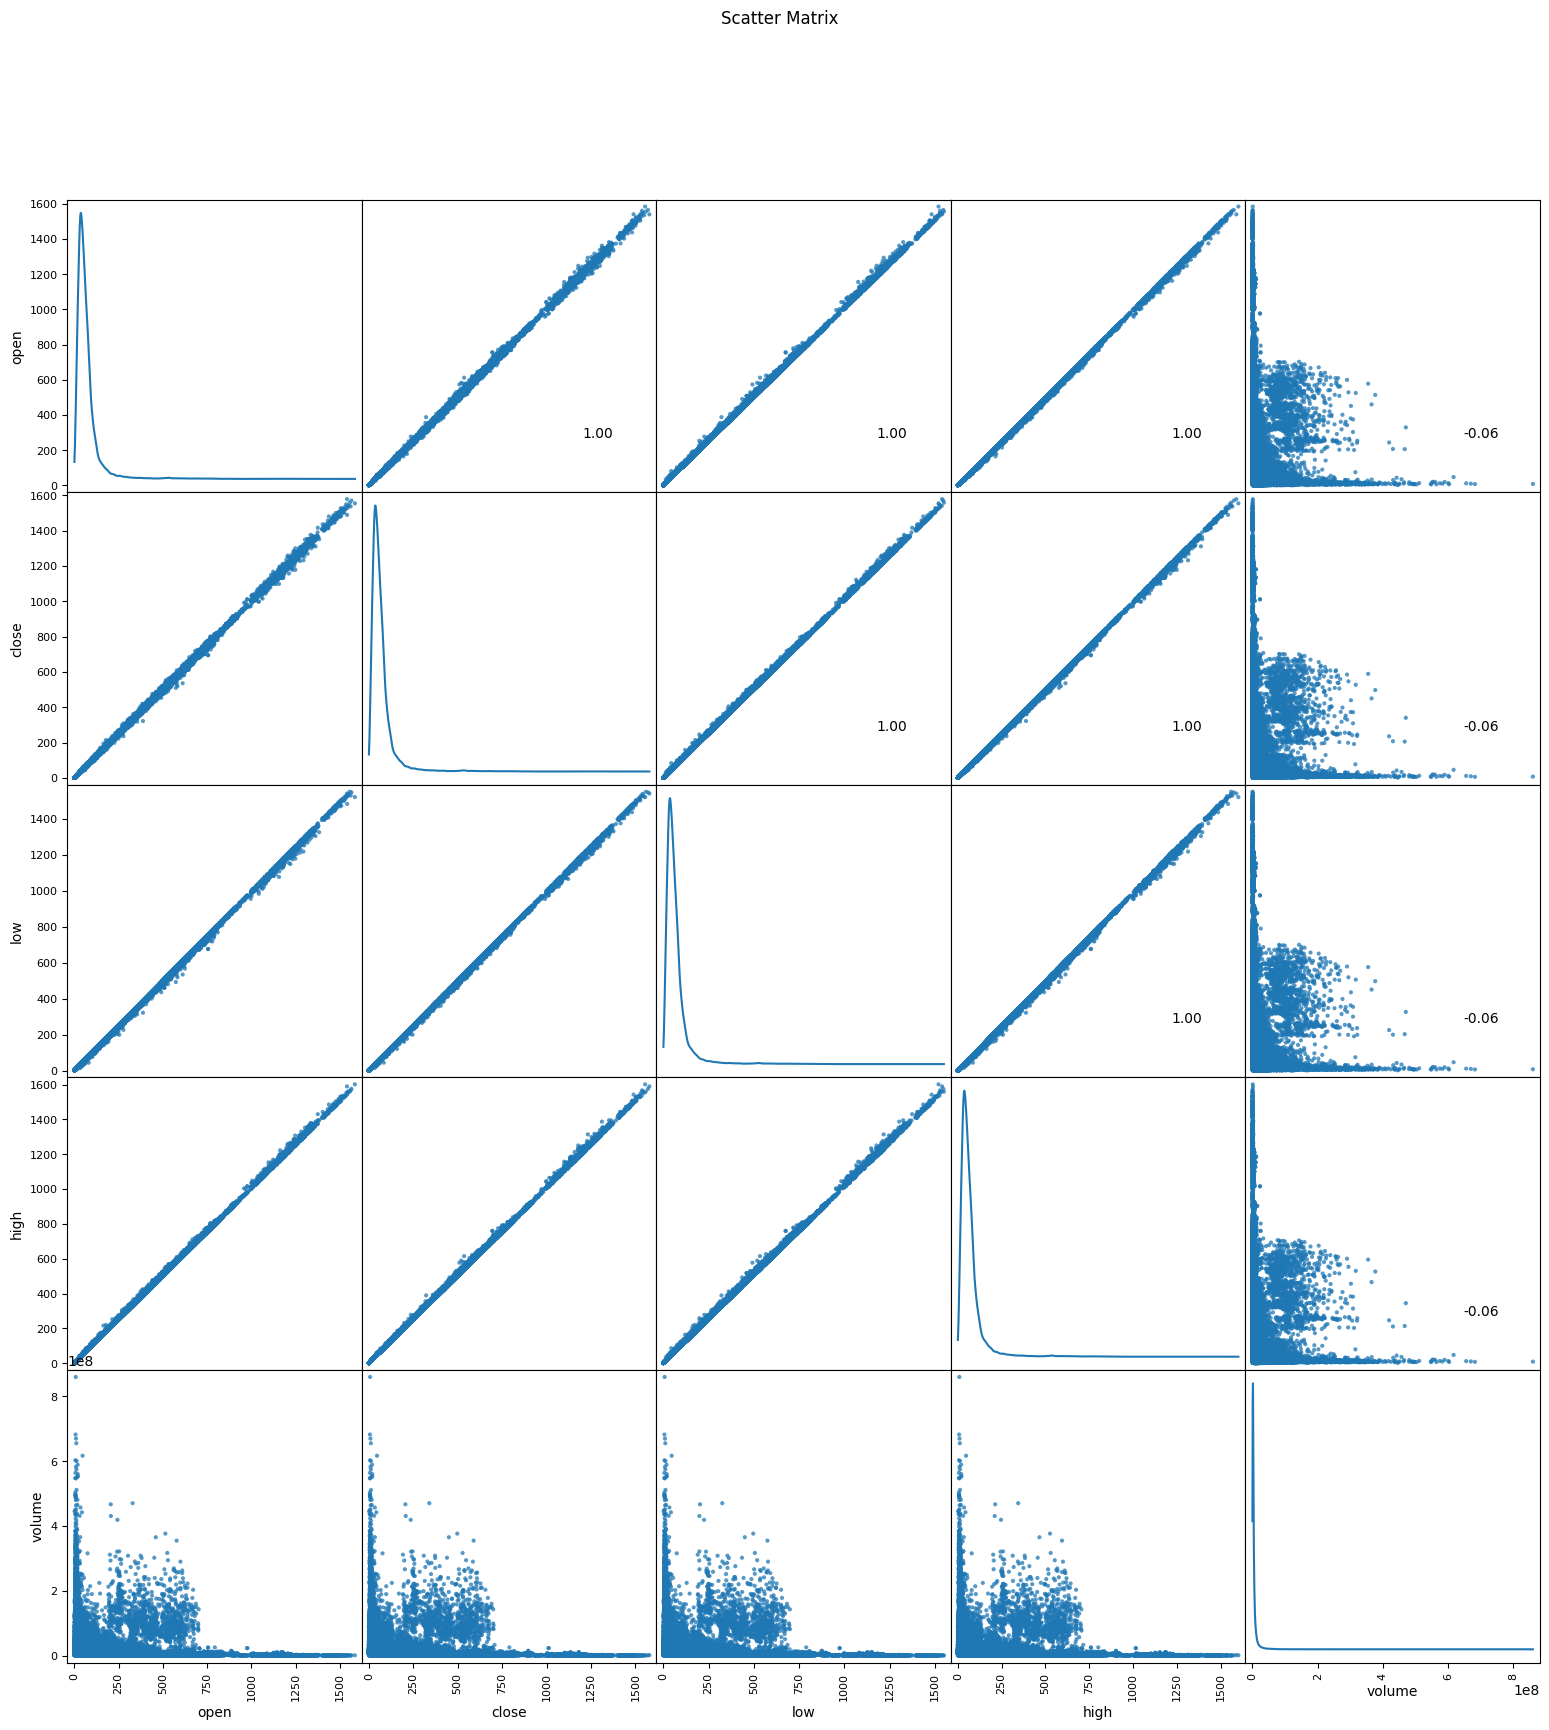

In [ ]:
plotScatterMatrix(prices_df, 19, 10)

In [5]:
def extract_date_features(df, date_col='date', date_format='%Y-%m-%d'):
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    return df


In [6]:
df = extract_date_features(prices_df)

In [7]:
df['prev_close'] = df.groupby('symbol')['close'].shift(1)
df['close_rolling_mean_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
df['close_rolling_std_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())

In [8]:
prices_df['daily_return'] = prices_df.groupby('symbol')['close'].pct_change()

In [9]:
fundamentals_df['debt_to_equity'] = fundamentals_df['Total Liabilities'] / fundamentals_df['Total Equity']
fundamentals_df['current_ratio'] = fundamentals_df['Total Current Assets'] / fundamentals_df['Total Current Liabilities']
fundamentals_df['return_on_assets'] = fundamentals_df['Net Income'] / fundamentals_df['Total Assets']

In [10]:
combined_df = pd.merge(prices_df, fundamentals_df, left_on=['symbol', 'year'], right_on=['Ticker Symbol', 'For Year'], how='left')

In [11]:
print(combined_df.head())

        date symbol        open       close         low        high  \
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  year  month  day  ...  Total Liabilities  \
0  2163600.0  2016      1    5  ...                NaN   
1  2386400.0  2016      1    6  ...                NaN   
2  2489500.0  2016      1    7  ...                NaN   
3  2006300.0  2016      1    8  ...                NaN   
4  1408600.0  2016      1   11  ...                NaN   

   Total Liabilities & Equity  Total Revenue  Treasury Stock  For Year  \
0                         NaN            NaN             NaN       NaN   
1                         NaN            NaN             NaN       NaN   
2 

In [12]:
combined_df = combined_df.iloc[:, :15]

In [13]:
combined_df = combined_df.fillna(method='bfill')

<ipython-input-13-4a1070dfbd1e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='bfill')


In [14]:
boolean_cols = combined_df.select_dtypes(include=['bool']).columns

combined_df[boolean_cols] = combined_df[boolean_cols].astype(int)

In [15]:
print(combined_df)

             date symbol        open       close         low        high  \
0      2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1      2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2      2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3      2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4      2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...           ...    ...         ...         ...         ...         ...   
852769 2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
852770 2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
852771 2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
852772 2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
852773 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month  day  day_of_week  prev_close  \
0       2163600.0  2016

In [17]:
plotCorrelationMatrix(combined_df, 30)

NameError: name 'plotCorrelationMatrix' is not defined

In [ ]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl3b6pe8_
  JVM stdout: /tmp/tmpl3b6pe8_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl3b6pe8_/h2o_unknownUser_started_from_python.err


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_7mt775
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [41]:
symbols_to_select = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']


In [ ]:

results = {}


In [ ]:
def train_and_evaluate_model(symbol, combined_df):
    filtered_df = combined_df[combined_df['symbol'] == symbol].drop(columns=['symbol'])

    X = filtered_df.drop(['close'], axis=1)
    y = filtered_df['close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
    test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

    aml = H2OAutoML(max_runtime_secs=300, seed=1)
    aml.train(x=list(X_train.columns), y='close', training_frame=train_h2o, leaderboard_frame=test_h2o)

    lb = aml.leaderboard.as_data_frame(use_multi_thread=True)
    best_model = aml.leader

    predictions = best_model.predict(test_h2o)

    predictions_df = predictions.as_data_frame()

    rmse = np.sqrt(mean_squared_error(test_h2o['close'].as_data_frame(), predictions_df['predict']))

    plot_model_performance(test_h2o, predictions_df, X_test.columns, 'date')

    return {
        'leaderboard': lb,
        'best_model': best_model,
        'predictions': predictions_df,
        'rmse': rmse
    }

def plot_model_performance(test_h2o, predictions_df, feature_columns, time_column='date'):
    time_series = test_h2o[time_column].as_data_frame()
    actual_values = test_h2o['close'].as_data_frame()

    time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

    df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
    df.columns = [time_column, 'Actual', 'Predicted']

    df = df.sort_values(by=time_column)

    plt.figure(figsize=(14, 8))
    plt.plot(df[time_column], df['Actual'], label='Actual')
    plt.plot(df[time_column], df['Predicted'], label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,36 mins 07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_7mt775
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Processing symbol: AAPL
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

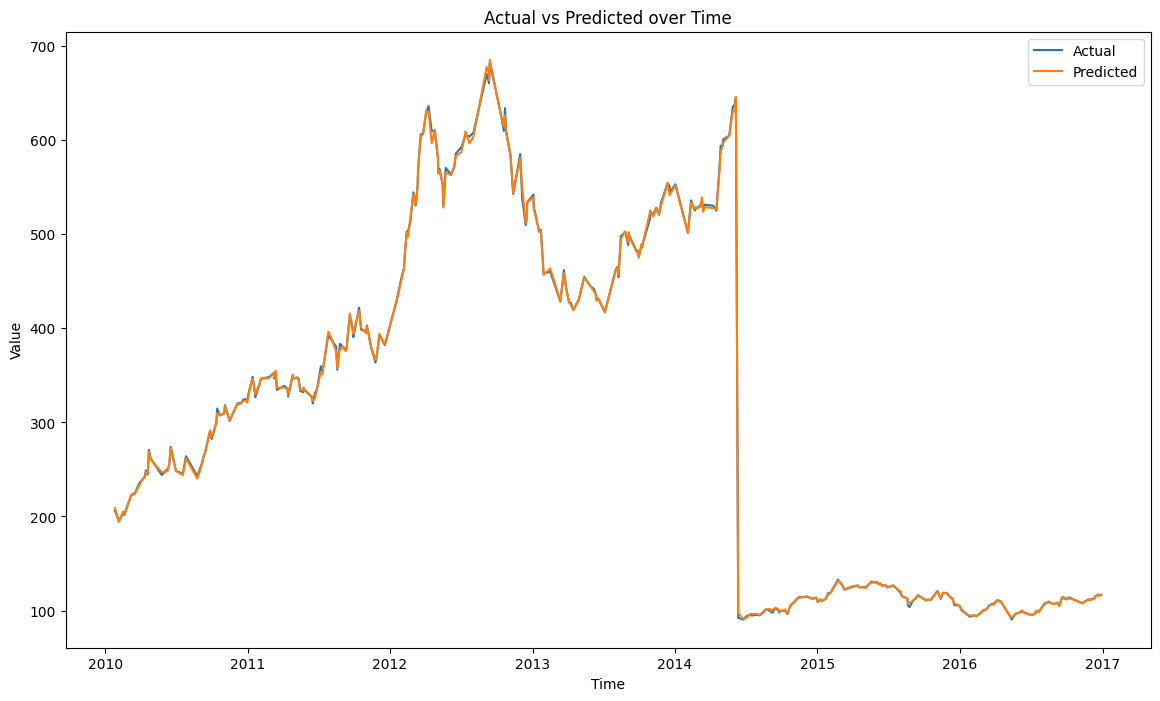

Leaderboard for AAPL:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_1_202409...  2.279635  5.196737   
1       GBM_grid_1_AutoML_1_20240903_161307_model_26  2.413646  5.825689   
2  StackedEnsemble_BestOfFamily_3_AutoML_1_202409...  2.435640  5.932342   
3  StackedEnsemble_BestOfFamily_2_AutoML_1_202409...  2.436407  5.936081   
4       GBM_grid_1_AutoML_1_20240903_161307_model_32  2.447348  5.989511   

        mae     rmsle  mean_residual_deviance  
0  1.415128  0.007342                5.196737  
1  1.472419  0.007919                5.825689  
2  1.426357  0.006342                5.932342  
3  1.427394  0.006347                5.936081  
4  1.436422  0.006722                5.989511  
RMSE for AAPL: 2.2796359335431196

Processing symbol: GOOGL
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

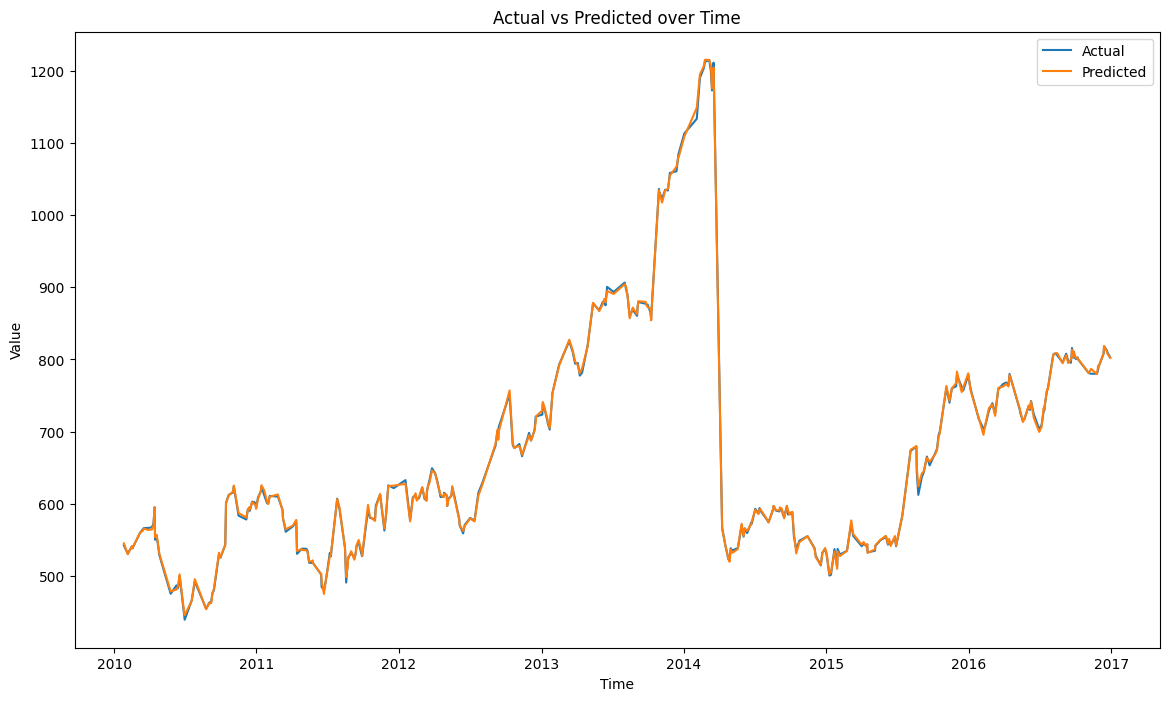

Leaderboard for GOOGL:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_4_AutoML_2_202409...  2.942633  8.659090   
1       GBM_grid_1_AutoML_2_20240903_161810_model_32  2.997440  8.984649   
2       GBM_grid_1_AutoML_2_20240903_161810_model_44  3.047306  9.286075   
3  StackedEnsemble_BestOfFamily_1_AutoML_2_202409...  3.120610  9.738205   
4  StackedEnsemble_BestOfFamily_3_AutoML_2_202409...  3.142253  9.873755   

        mae     rmsle  mean_residual_deviance  
0  2.245210  0.004450                8.659090  
1  2.293924  0.004538                8.984649  
2  2.318652  0.004570                9.286075  
3  2.150488  0.004473                9.738205  
4  2.291579  0.004629                9.873755  
RMSE for GOOGL: 2.942632937285279

Processing symbol: MSFT
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

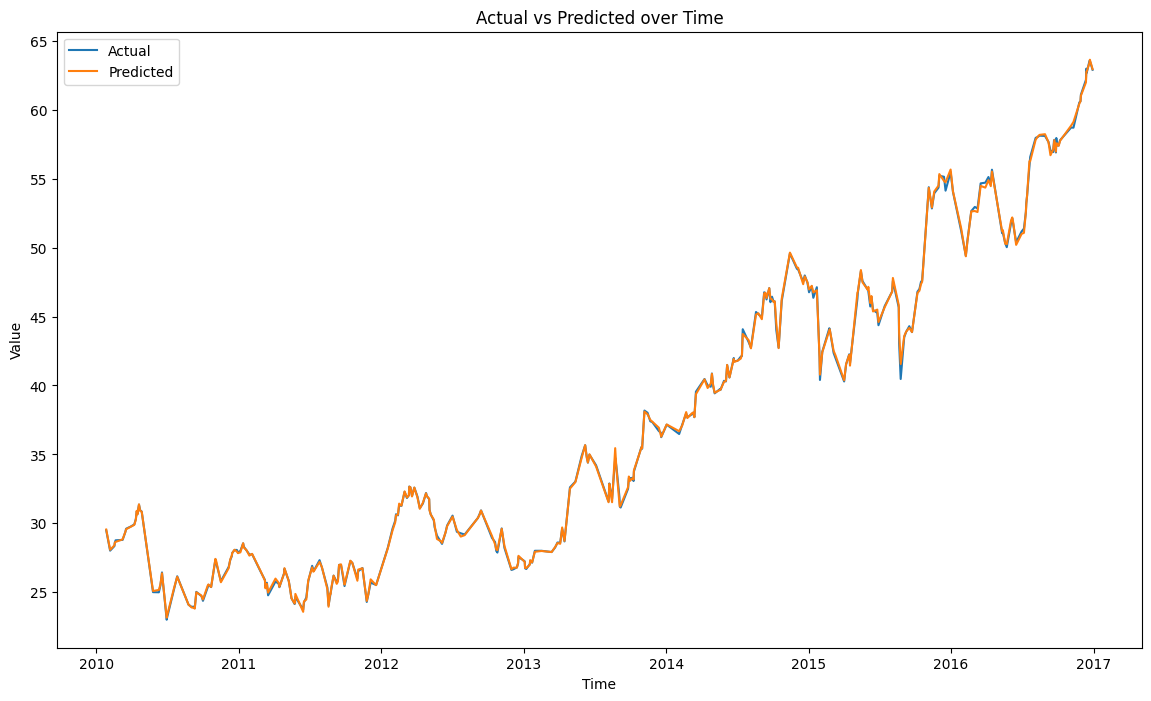

Leaderboard for MSFT:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_1_AutoML_3_202409...  0.155243  0.024100   
1  StackedEnsemble_BestOfFamily_2_AutoML_3_202409...  0.155816  0.024279   
2  StackedEnsemble_AllModels_1_AutoML_3_20240903_...  0.155834  0.024284   
3  StackedEnsemble_AllModels_2_AutoML_3_20240903_...  0.156064  0.024356   
4  StackedEnsemble_BestOfFamily_3_AutoML_3_202409...  0.156082  0.024362   

        mae     rmsle  mean_residual_deviance  
0  0.102800  0.003852                0.024100  
1  0.102733  0.003847                0.024279  
2  0.102732  0.003847                0.024284  
3  0.103093  0.003850                0.024356  
4  0.103090  0.003850                0.024362  
RMSE for MSFT: 0.1552428769064715

Processing symbol: AMZN
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |██████████████████████████████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow a

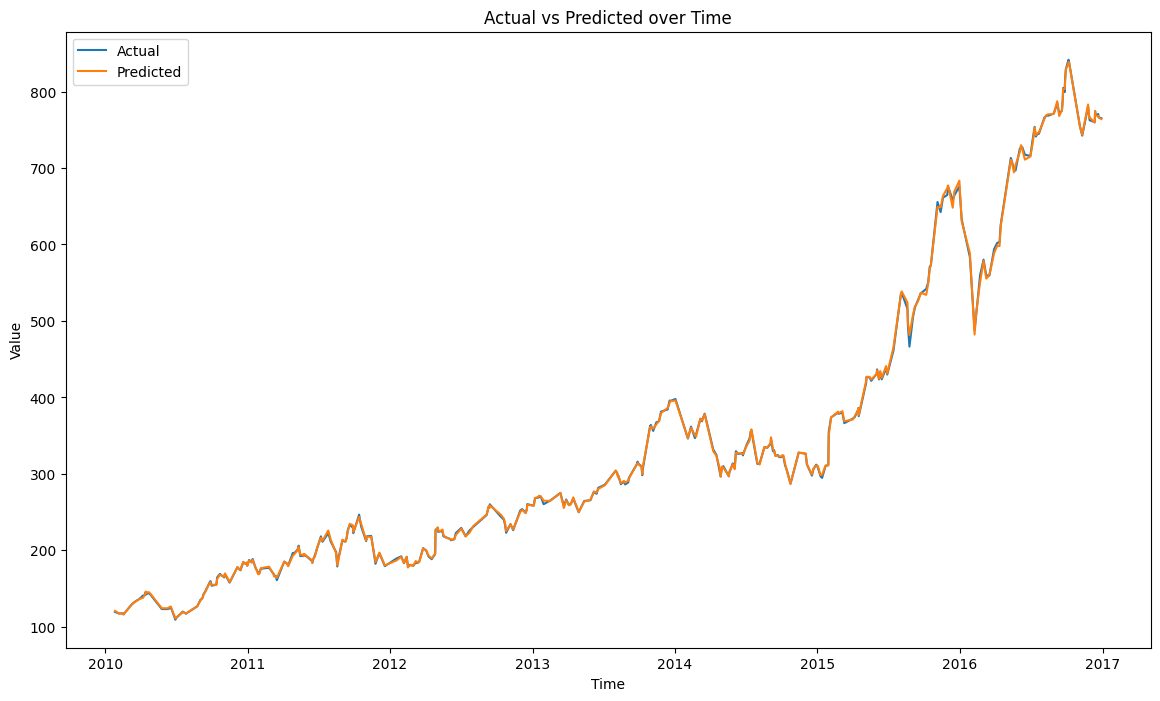

Leaderboard for AMZN:
                                            model_id      rmse       mse  \
0  StackedEnsemble_BestOfFamily_3_AutoML_4_202409...  2.397321  5.747146   
1  StackedEnsemble_BestOfFamily_4_AutoML_4_202409...  2.440659  5.956817   
2       GBM_grid_1_AutoML_4_20240903_162818_model_23  2.484084  6.170673   
3  StackedEnsemble_AllModels_2_AutoML_4_20240903_...  2.495898  6.229509   
4  StackedEnsemble_BestOfFamily_2_AutoML_4_202409...  2.535092  6.426691   

        mae     rmsle  mean_residual_deviance  
0  1.626858  0.006649                5.747146  
1  1.640822  0.007432                5.956817  
2  1.682354  0.007578                6.170673  
3  1.716855  0.007213                6.229509  
4  1.677914  0.007023                6.426691  
RMSE for AMZN: 2.397320556082829



In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
for symbol in symbols_to_select:
    print(f"Processing symbol: {symbol}")
    result = train_and_evaluate_model(symbol, combined_df)

    results[symbol] = result

    print(f"Leaderboard for {symbol}:")
    print(result['leaderboard'].head())
    print(f"RMSE for {symbol}: {result['rmse']}\n")


In [ ]:
for symbol, result in results.items():
    print(f"Results for {symbol}:")
    print("Leaderboard:")
    print(result['leaderboard'].head())
    print(f"RMSE: {result['rmse']}")
    print("-" * 30)


In [ ]:
X = combined_df.drop(['close'], axis=1)
y = combined_df['close']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

In [ ]:
target_column = 'close'
time_column = 'date'

In [ ]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=300,  # Adjust as needed
                   seed=1)
aml.train(x=list(X_train.columns),
          y=target_column,
          training_frame=train_h2o,
          leaderboard_frame=test_h2o,)

In [ ]:
lb = aml.leaderboard
print(lb)

In [ ]:
best_model = aml.leader

In [ ]:
predictions = best_model.predict(test_h2o)

In [ ]:
predictions_df = predictions.as_data_frame()

In [ ]:
try:
    lb_df = aml.leaderboard.as_data_frame(use_multi_thread=True)
except ImportError:
    lb_df = aml.leaderboard.as_data_frame()

In [ ]:
print(lb_df.head())
print(lb_df.columns)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the metric column to one of the existing columns
metric_column = 'rmse'  # You can change this to 'mse', 'mae', 'rmsle', etc.

# Plot the leaderboard
plt.figure(figsize=(5, 3))
sns.barplot(x='model_id', y=metric_column, data=lb_df)
plt.xticks(rotation=90)
plt.title(f'Leaderboard - {metric_column}')
plt.xlabel('Model ID')
plt.ylabel(metric_column)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert H2OFrames to Pandas DataFrames
time_series = test_h2o[time_column].as_data_frame()
actual_values = test_h2o[target_column].as_data_frame()

# Convert time column from milliseconds to datetime
time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

# Combine the data into a single DataFrame for easier sorting
df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
df.columns = [time_column, 'Actual', 'Predicted']

# Sort by time column to ensure the plot is in chronological order
df = df.sort_values(by=time_column)

# Extract the year from the datetime column
df['Year'] = df[time_column].dt.year

# Aggressively downsample the data for better visibility
df = df.sample(frac=0.05, random_state=42)

# Get the unique years in the dataset
years = df['Year'].unique()

# Create subplots - one for each year, separating actual and predicted plots
fig, axes = plt.subplots(len(years), 2, figsize=(14, 5 * len(years)), sharex=True, sharey=True)

# Plot each year separately
for i, year in enumerate(years):
    # Filter data for the current year
    df_year = df[df['Year'] == year]

    # Scatter plot for actual values
    axes[i, 0].scatter(df_year[time_column], df_year['Actual'], label='Actual', color='blue', alpha=0.5)
    axes[i, 0].set_title(f'Actual - {year}')
    axes[i, 0].set_ylabel('Value')

    # Scatter plot for predicted values
    axes[i, 1].scatter(df_year[time_column], df_year['Predicted'], label='Predicted', color='orange', alpha=0.5)
    axes[i, 1].set_title(f'Predicted - {year}')

    # Add legend
    axes[i, 0].legend()
    axes[i, 1].legend()

    # Optionally set y-axis limits (modify as needed)
    axes[i, 0].set_ylim([0, df['Actual'].max() + 100])

# Set common labels
plt.xlabel('Time')
plt.tight_layout()

# Show plot
plt.show()


In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout, Input  # Added Input layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import for RMSE, MAE calculation


# Initialize a dictionary to store results for each symbol
results = {}

def preprocess_data(symbol, combined_df):
    """
    Preprocess the data for the given symbol.
    """
    # Filter the DataFrame to include only rows with the specified symbol
    symbol_df = combined_df[combined_df['symbol'] == symbol].drop(columns=['symbol'])

    # Drop the 'date' column since it’s not needed for the LSTM model
    df = symbol_df.drop(columns=['date'])

    # Normalize the DataFrame using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for 'close' column only
    scaled_df = scaler.fit_transform(df)

    # Scale the 'close' column separately for proper inverse transformation later
    df['close'] = close_scaler.fit_transform(df[['close']])

    # Convert back to DataFrame for easier handling
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

    # Prepare the data for LSTM
    close_index = scaled_df.columns.get_loc("close")
    sequence_length = 100  # Use the past 100 days to predict the next day
    X, y = [], []

    for i in range(sequence_length, len(scaled_df)):
        X.append(scaled_df.iloc[i-sequence_length:i].values)
        y.append(scaled_df.iloc[i, close_index])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler, close_scaler

def lstm(X_train, y_train, X_test, y_test):
    """
    Train LSTM model with the given data.
    """
    # Initialize the LSTM model
    model = Sequential()

    # Add Input layer and LSTM layers with dropout to prevent overfitting
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape using Input layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Add a Dense layer to output the close price prediction
    model.add(Dense(units=1))  # Only one output for the close price

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    return model, test_loss

def rnn(X_train, y_train, X_test, y_test):
    """
    Train RNN model with the given data.
    """
    # Initialize the RNN model
    model = Sequential()

    # Add Input layer and SimpleRNN layers with dropout to prevent overfitting
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape using Input layer
    model.add(SimpleRNN(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Add a Dense layer to output the close price prediction
    model.add(Dense(units=1))  # Only one output for the close price

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    return model, test_loss

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics: MSE, RMSE, MAPE, and MAE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    return mse, rmse, mae, mape

def predict(model_function):
    """
    Predict stock prices using the given model function (either lstm or rnn).
    """
    # Loop through each symbol
    for symbol in symbols_to_select:
        print(f"\nProcessing symbol: {symbol}")

        # Preprocess data for the current symbol
        X, y, scaler, close_scaler = preprocess_data(symbol, combined_df)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the model using the provided model function (lstm or rnn)
        model, test_loss = model_function(X_train, y_train, X_test, y_test)

        # Predict on the test set
        predicted = model.predict(X_test)

        # Inverse transform to get the actual price scale for the 'close' column only
        predicted_actual = close_scaler.inverse_transform(predicted)
        y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate MSE, RMSE, MAE, MAPE
        mse, rmse, mae, mape = calculate_metrics(y_test_actual, predicted_actual)
        print(f'MSE for {symbol}: {mse}')
        print(f'RMSE for {symbol}: {rmse}')
        print(f'MAE for {symbol}: {mae}')
        print(f'MAPE for {symbol}: {mape}')

        # Store the results
        results[symbol] = {'model': model, 'test_loss': test_loss, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}

        # Plot the actual vs predicted values
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_actual, color='black', label='Actual Close Price')
        plt.plot(predicted_actual, color='green', label='Predicted Close Price')
        plt.title(f'Stock Price Prediction for {symbol}')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    # Display summary results
    for symbol, result in results.items():
        print(f"Symbol: {symbol}, Test Loss: {result['test_loss']}, MSE: {result['mse']}, RMSE: {result['rmse']}, MAE: {result['mae']}, MAPE: {result['mape']}")




Processing symbol: AAPL
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.5645e-04
Test Loss: 0.0006229518330655992
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
MSE for AAPL: 233.18557912632699
RMSE for AAPL: 15.270415158938116
MAE for AAPL: 13.012815842381935
MAPE for AAPL: 7.329869506954015


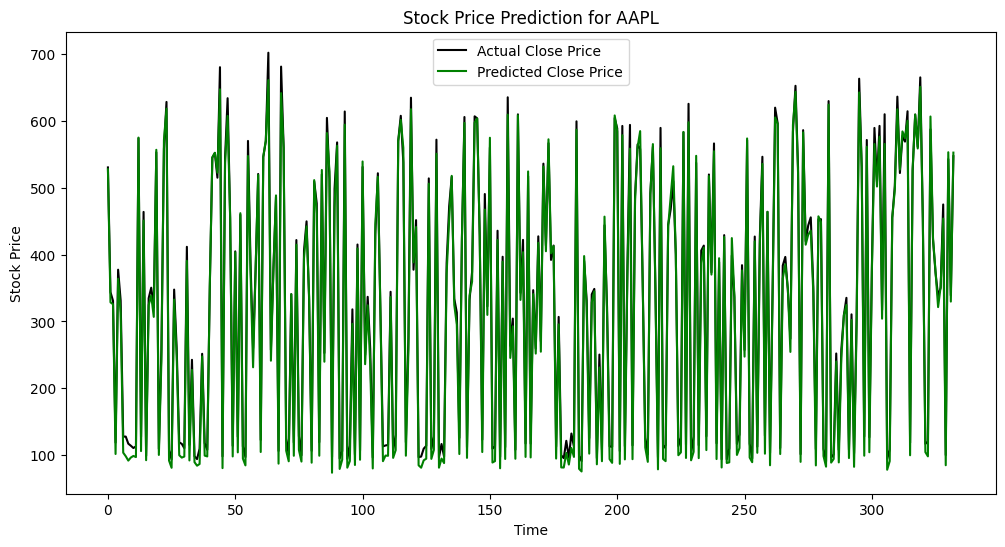


Processing symbol: GOOGL


In [ ]:
predict(rnn)

In [ ]:
predict(lstm)

In [23]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers with dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer to output the close price prediction
model.add(Dense(units=1))  # Only one output for the close price

optimizer = Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Extract the 'close' column from the original DataFrame for inverse scaling
close_scaler = MinMaxScaler(feature_range=(0, 1)) # Create a new scaler for just the close column
close_scaler.fit(df['close'].values.reshape(-1, 1)) # Fit it to the original close values


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0269 - val_loss: 0.0010
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - val_loss: 8.4485e-04
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 6.3237e-04
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0045 - val_loss: 7.4749e-04
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - val_loss: 5.8027e-04
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - val_loss: 6.1753e-04
Epoch 9/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038 - val_loss: 8.9191e-04
Epoch 10/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0040 - val_loss: 9.5476e-04
Epoch 11/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 9.5665e-04
Epoch 1

MinMaxScaler()

In [24]:
"""import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [8, 16, 32],
    'epochs': [50, 100],
    'learning_rate': [0.001, 0.01]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To store the best score and the corresponding hyperparameters
best_score = float('inf')
best_params = {}

# Grid search
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")

                    # Build the model
                    model = Sequential()
                    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout_rate))
                    model.add(LSTM(units=units, return_sequences=False))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(units=1))

                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='mean_squared_error')

                    # Train the model
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

                    # Evaluate the model
                    score = model.evaluate(X_test, y_test, verbose=0)
                    print(f"Validation loss: {score}")

                    # If this score is better, update best_score and best_params
                    if score < best_score:
                        best_score = score
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'learning_rate': learning_rate
                        }

print(f"Best Validation Loss: {best_score}")
print(f"Best Hyperparameters: {best_params}")
"""

'import numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nfrom tensorflow.keras.optimizers import Adam\n\n# Define the hyperparameter grid\nparam_grid = {\n    \'units\': [50, 100, 150],\n    \'dropout_rate\': [0.2, 0.3],\n    \'batch_size\': [8, 16, 32],\n    \'epochs\': [50, 100],\n    \'learning_rate\': [0.001, 0.01]\n}\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# To store the best score and the corresponding hyperparameters\nbest_score = float(\'inf\')\nbest_params = {}\n\n# Grid search\nfor units in param_grid[\'units\']:\n    for dropout_rate in param_grid[\'dropout_rate\']:\n        for batch_size in param_grid[\'batch_size\']:\n            for epochs in param_grid[\'epochs\']:\n                for learning_rate in param_grid[\'learning_rate\']:\n           

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


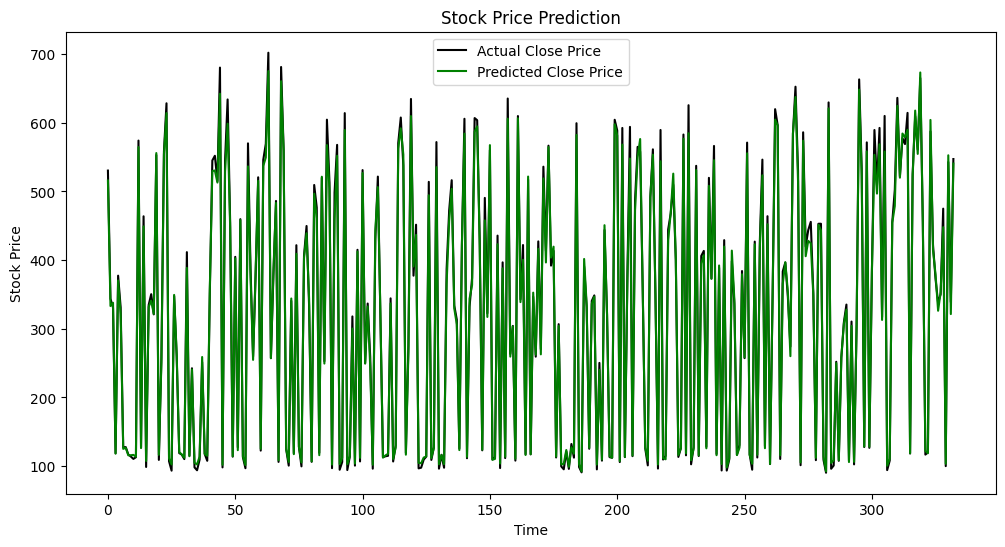

In [25]:
predicted = model.predict(X_test)
# Inverse transform the predicted and actual close prices
predicted = close_scaler.inverse_transform(predicted) # Use the new scaler to inverse transform
y_test = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, color='black', label='Actual Close Price')
plt.plot(predicted, color='green', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f'RMSE: {rmse}')


RMSE: 12.029901360585717
